# Bitcoin Market Price Prediction
## Divya Jayaprakash

Start by importing all the libraries and the training and test datasets. 

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, validation_curve, StratifiedKFold, GridSearchCV

data = pd.read_csv('bitcoin_dataset.csv')
test = pd.read_csv('test_set.csv')

In [2]:
print(data.columns)
print(test.columns)

Index(['Date', 'btc_market_price', 'btc_total_bitcoins', 'btc_market_cap',
       'btc_trade_volume', 'btc_blocks_size', 'btc_avg_block_size',
       'btc_n_orphaned_blocks', 'btc_n_transactions_per_block',
       'btc_median_confirmation_time', 'btc_hash_rate', 'btc_difficulty',
       'btc_miners_revenue', 'btc_transaction_fees',
       'btc_cost_per_transaction_percent', 'btc_cost_per_transaction',
       'btc_n_unique_addresses', 'btc_n_transactions',
       'btc_n_transactions_total', 'btc_n_transactions_excluding_popular',
       'btc_n_transactions_excluding_chains_longer_than_100',
       'btc_output_volume', 'btc_estimated_transaction_volume',
       'btc_estimated_transaction_volume_usd'],
      dtype='object')
Index(['Date', 'btc_total_bitcoins', 'btc_market_cap', 'btc_trade_volume',
       'btc_blocks_size', 'btc_avg_block_size', 'btc_n_orphaned_blocks',
       'btc_n_transactions_per_block', 'btc_median_confirmation_time',
       'btc_hash_rate', 'btc_difficulty', 'btc_min

## Data Cleaning and Imputation

The next cell renames all the columns other than the date column

In [3]:
for col in data.columns[1:]:
    data.rename(columns={col:col[4:]}, inplace = True)

for col in test.columns[1:]:
    test.rename(columns={col:col[4:]}, inplace=True)

In [4]:
print(data.columns)
print(test.columns)

Index(['Date', 'market_price', 'total_bitcoins', 'market_cap', 'trade_volume',
       'blocks_size', 'avg_block_size', 'n_orphaned_blocks',
       'n_transactions_per_block', 'median_confirmation_time', 'hash_rate',
       'difficulty', 'miners_revenue', 'transaction_fees',
       'cost_per_transaction_percent', 'cost_per_transaction',
       'n_unique_addresses', 'n_transactions', 'n_transactions_total',
       'n_transactions_excluding_popular',
       'n_transactions_excluding_chains_longer_than_100', 'output_volume',
       'estimated_transaction_volume', 'estimated_transaction_volume_usd'],
      dtype='object')
Index(['Date', 'total_bitcoins', 'market_cap', 'trade_volume', 'blocks_size',
       'avg_block_size', 'n_orphaned_blocks', 'n_transactions_per_block',
       'median_confirmation_time', 'hash_rate', 'difficulty', 'miners_revenue',
       'transaction_fees', 'cost_per_transaction_percent',
       'cost_per_transaction', 'n_unique_addresses', 'n_transactions',
       'n_tra

Set the index to date. This can be used to plot according to time and use for imputation.

In [5]:
data.head()
data["Date"] = pd.to_datetime(data["Date"])
test["Date"] = pd.to_datetime(test["Date"])
data = data.set_index("Date")
test = test.set_index("Date")

Check the percentage of missing values in the training data and the test data

In [6]:
print(100*data.isnull().sum().sum() / data.shape[0]) #4% overall nulls in train
print(100*test.isnull().sum().sum() / test.shape[0]) #0% here

3.9573296627666896
0.0


Print the percentage of missing values in each column

In [7]:
print(100*data.isnull().sum() / data.shape[0]) 

market_price                                       0.000000
total_bitcoins                                     0.929112
market_cap                                         0.000000
trade_volume                                       0.722643
blocks_size                                        0.997935
avg_block_size                                     0.000000
n_orphaned_blocks                                  0.000000
n_transactions_per_block                           0.000000
median_confirmation_time                           0.412939
hash_rate                                          0.000000
difficulty                                         0.550585
miners_revenue                                     0.000000
transaction_fees                                   0.344116
cost_per_transaction_percent                       0.000000
cost_per_transaction                               0.000000
n_unique_addresses                                 0.000000
n_transactions                          

Plot the missing values columns to see the trend(or pattern) to decide on how to impute

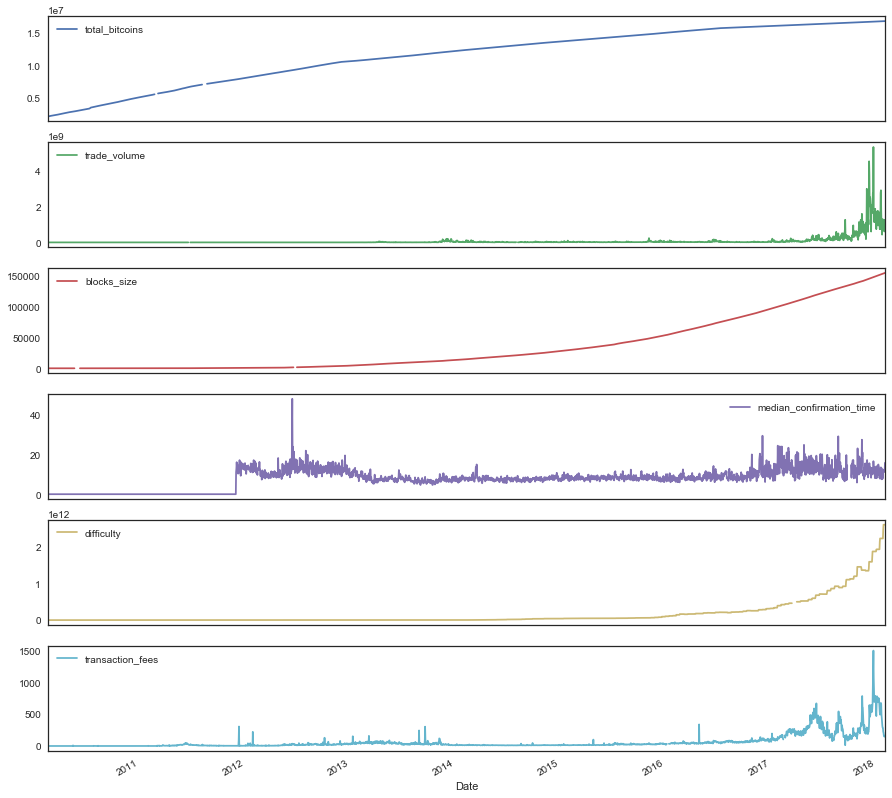

In [8]:
sns.set_style("white")
data[["total_bitcoins","trade_volume","blocks_size",
      "median_confirmation_time", "difficulty","transaction_fees"]].plot(subplots=True, figsize=(15, 15)); plt.legend(loc='best')

The ColsToImpute below has features with mostly a linear trend near the missing values. So, we are using a linear interpolation method with time to impute them. <br>
After this, only the median_confirmation_time column will have missing values and it is reasonable to fill them using the mean value because it has most of it's values 0 and 47 with mean around 7.5

In [9]:
ColsToImpute = ["total_bitcoins","trade_volume","blocks_size","difficulty","transaction_fees"]
data[ColsToImpute] = data[ColsToImpute].interpolate(method="time")
data = data.fillna(data.mean())

Now, we don't require the date column so reset the index and remove the date column

In [10]:
data = data.reset_index()
test = test.reset_index()
data = data.drop('Date', 1)
test = test.drop('Date', 1)
print(data.columns)
print(test.columns)

Index(['market_price', 'total_bitcoins', 'market_cap', 'trade_volume',
       'blocks_size', 'avg_block_size', 'n_orphaned_blocks',
       'n_transactions_per_block', 'median_confirmation_time', 'hash_rate',
       'difficulty', 'miners_revenue', 'transaction_fees',
       'cost_per_transaction_percent', 'cost_per_transaction',
       'n_unique_addresses', 'n_transactions', 'n_transactions_total',
       'n_transactions_excluding_popular',
       'n_transactions_excluding_chains_longer_than_100', 'output_volume',
       'estimated_transaction_volume', 'estimated_transaction_volume_usd'],
      dtype='object')
Index(['total_bitcoins', 'market_cap', 'trade_volume', 'blocks_size',
       'avg_block_size', 'n_orphaned_blocks', 'n_transactions_per_block',
       'median_confirmation_time', 'hash_rate', 'difficulty', 'miners_revenue',
       'transaction_fees', 'cost_per_transaction_percent',
       'cost_per_transaction', 'n_unique_addresses', 'n_transactions',
       'n_transactions_total'

Split the "data" dataframe into dependent and independent variables

In [11]:
X_btc = data[data.columns[1:len(data.columns)]]
y_btc = data['market_price']

Split into training and test dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_btc, y_btc, test_size=0.3, random_state=1)

We are using scaled data to run most of our models for better computation and convergence

In [13]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Building

### KNN Regressor

Run the KNN Regressor for K from 1 to 19;
For K = 2 we are getting the best test accuracy. So the train accuracy is 0.9979 and test accuracy is 0.9944 for KNN regressor.

In [14]:
for num_neighbors in range(1, 20):
    knnreg = KNeighborsRegressor(n_neighbors = num_neighbors).fit(X_train_scaled, y_train)

    #print(knnreg.predict(X_test_scaled))
    print('R-squared train score for {} neighbors: {:.4f}'
         .format(num_neighbors, knnreg.score(X_train_scaled, y_train)))
    print('R-squared test score for {} neighbors: {:.4f}'
         .format(num_neighbors, knnreg.score(X_test_scaled, y_test)))

R-squared train score for 1 neighbors: 1.0000
R-squared test score for 1 neighbors: 0.9953
R-squared train score for 2 neighbors: 0.9984
R-squared test score for 2 neighbors: 0.9956
R-squared train score for 3 neighbors: 0.9975
R-squared test score for 3 neighbors: 0.9951
R-squared train score for 4 neighbors: 0.9969
R-squared test score for 4 neighbors: 0.9941
R-squared train score for 5 neighbors: 0.9964
R-squared test score for 5 neighbors: 0.9940
R-squared train score for 6 neighbors: 0.9958
R-squared test score for 6 neighbors: 0.9937
R-squared train score for 7 neighbors: 0.9955
R-squared test score for 7 neighbors: 0.9932
R-squared train score for 8 neighbors: 0.9950
R-squared test score for 8 neighbors: 0.9931
R-squared train score for 9 neighbors: 0.9942
R-squared test score for 9 neighbors: 0.9925
R-squared train score for 10 neighbors: 0.9938
R-squared test score for 10 neighbors: 0.9925
R-squared train score for 11 neighbors: 0.9934
R-squared test score for 11 neighbors: 0.

### Linear Regression

Next, we used linear regression to predict the market price. The train accuracy is 0.999964 and test accuracy is 0.999936. As we can see that Linear Regression performs better we will not consider KNN for further analysis.

In [15]:
linregscaled = LinearRegression().fit(X_train_scaled, y_train)

print('R-squared score (training): {:.6f}'
     .format(linregscaled.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.6f}'
     .format(linregscaled.score(X_test_scaled, y_test)))

R-squared score (training): 0.999964
R-squared score (test): 0.999936


### Ridge Regression

Next, we try Ridge regression with different values of alpha. This seems to perform good with very low values of alpha.

In [16]:
print('Ridge regression: Trying different values of alpha')
for this_alpha in [0, 0.001, 0.01, 1, 10, 20, 50, 100, 1000]:
    linRidge = Ridge(alpha=this_alpha).fit(X_train_scaled, y_train)
    r2_train = linRidge.score(X_train_scaled, y_train)
    r2_test = linRidge.score(X_test_scaled, y_test)
    num_coeff_big = np.sum(abs(linRidge.coef_) > 1.0)
    print('Alpha = {:.7f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.7f}, r-squared test: {:.7f}\n'
         .format(this_alpha, num_coeff_big, r2_train, r2_test))

Ridge regression: Trying different values of alpha
Alpha = 0.0000000
num abs(coeff) > 1.0: 21, r-squared training: 0.9999643, r-squared test: 0.9999359

Alpha = 0.0010000
num abs(coeff) > 1.0: 22, r-squared training: 0.9999639, r-squared test: 0.9999362

Alpha = 0.0100000
num abs(coeff) > 1.0: 22, r-squared training: 0.9999422, r-squared test: 0.9999156

Alpha = 1.0000000
num abs(coeff) > 1.0: 22, r-squared training: 0.9964708, r-squared test: 0.9961173

Alpha = 10.0000000
num abs(coeff) > 1.0: 22, r-squared training: 0.9825136, r-squared test: 0.9822755

Alpha = 20.0000000
num abs(coeff) > 1.0: 22, r-squared training: 0.9690109, r-squared test: 0.9687682

Alpha = 50.0000000
num abs(coeff) > 1.0: 19, r-squared training: 0.9240593, r-squared test: 0.9234065

Alpha = 100.0000000
num abs(coeff) > 1.0: 22, r-squared training: 0.8523003, r-squared test: 0.8506465

Alpha = 1000.0000000
num abs(coeff) > 1.0: 21, r-squared training: 0.4530536, r-squared test: 0.4612201



### Lasso Regression

Next, we try Lasso with alpha of 0.01 to start with and we can see that this does a pretty good job and gives similar result to Linear Regression.

In [17]:
linlasso = Lasso(alpha=0.01, max_iter=1000).fit(X_train_scaled, y_train)

print('R-squared score (training): {:.7f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.7f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X_train), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

R-squared score (training): 0.9999400
R-squared score (test): 0.9999034

Features with non-zero weight (sorted by absolute magnitude):
	market_cap, 18875.661
	hash_rate, -527.989
	cost_per_transaction, 489.360
	difficulty, 314.060
	n_transactions_excluding_chains_longer_than_100, 200.712
	estimated_transaction_volume_usd, 176.091
	miners_revenue, 136.160
	n_unique_addresses, 129.871
	transaction_fees, -108.028
	n_transactions, -105.063
	n_transactions_per_block, -84.301
	avg_block_size, -73.552
	n_transactions_total, 61.680
	n_transactions_excluding_popular, 56.950
	trade_volume, -39.029
	blocks_size, -36.146
	median_confirmation_time, 31.489
	total_bitcoins, 30.692
	estimated_transaction_volume, -16.464
	output_volume, -7.144
	cost_per_transaction_percent, 2.153
	n_orphaned_blocks, 1.687


Next, we try Lasso with different values of alpha to see the behaviour by varying alpha and when alpha is 0.01 it is performing the best on the test set.

In [18]:
print('Trying Lasso for different values of alpha')

for alpha in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 3, 5, 10]:
    linLasso = Lasso(alpha, max_iter=10000).fit(X_train_scaled, y_train)
    r2_train = linLasso.score(X_train_scaled, y_train)
    r2_test = linLasso.score(X_test_scaled, y_test)
    
    print('Alpha = {:.4f}\nFeatures kept: {}\nr-squared training: {:.7f}, \
r-squared test: {:.7f}\n'
         .format(alpha, np.sum(linLasso.coef_ != 0), r2_train, r2_test))

Trying Lasso for different values of alpha
Alpha = 0.0001
Features kept: 22
r-squared training: 0.9999393, r-squared test: 0.9999019

Alpha = 0.0010
Features kept: 22
r-squared training: 0.9999393, r-squared test: 0.9999021

Alpha = 0.0100
Features kept: 22
r-squared training: 0.9999400, r-squared test: 0.9999034

Alpha = 0.1000
Features kept: 9
r-squared training: 0.9999317, r-squared test: 0.9999013

Alpha = 0.2000
Features kept: 8
r-squared training: 0.9999224, r-squared test: 0.9998946

Alpha = 0.5000
Features kept: 6
r-squared training: 0.9999187, r-squared test: 0.9998895

Alpha = 1.0000
Features kept: 8
r-squared training: 0.9999031, r-squared test: 0.9998701

Alpha = 2.0000
Features kept: 4
r-squared training: 0.9998485, r-squared test: 0.9998136

Alpha = 3.0000
Features kept: 4
r-squared training: 0.9997858, r-squared test: 0.9997442

Alpha = 5.0000
Features kept: 4
r-squared training: 0.9995783, r-squared test: 0.9995290

Alpha = 10.0000
Features kept: 4
r-squared training: 0

### Polynomial Regression

Next, let us try polynomial regression because a lot of variables seamt to have a non-linear trend and kind of parabolic trend. As we can see in the result below, this is performing better than even linear regression with a better accuracy on both train and test set.

In [19]:
poly = PolynomialFeatures(degree=2)
X_F1_poly = poly.fit_transform(X_btc)

scaler = MinMaxScaler()
X_poly_scaled = scaler.fit_transform(X_F1_poly)

X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y_btc, test_size = 0.3, random_state = 1)

polyreg = LinearRegression().fit(X_train, y_train)

print('(poly deg 2) R-squared score (training): {:.7f}'
     .format(polyreg.score(X_train, y_train)))
print('(poly deg 2) R-squared score (test): {:.7f}\n'
     .format(polyreg.score(X_test, y_test)))

(poly deg 2) R-squared score (training): 0.9999983
(poly deg 2) R-squared score (test): 0.9999916



### Polynomial Regression with Ridge and Lasso

Next, we run Ridge with polynomial with Ridge and after seeing the result of the cell below we can see that if does not perform that better on the test set. Let us try Lasso next

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y_btc, test_size = 0.3, random_state = 1)

polyRidgeReg = Ridge(alpha = 0.1).fit(X_train, y_train)

print('Polynomial Regression with Regularization')

print('(poly deg 2 + ridge) R-squared score (training): {:.7f}'
     .format(polyRidgeReg.score(X_train, y_train)))
print('(poly deg 2 + ridge) R-squared score (test): {:.7f}'
     .format(polyRidgeReg.score(X_test, y_test)))

polyLassoReg = Lasso(alpha = 0.001).fit(X_train, y_train)

print('(poly deg 2 + lasso) R-squared score (training): {:.7f}'
     .format(polyLassoReg.score(X_train, y_train)))
print('(poly deg 2 + lasso) R-squared score (test): {:.7f}'
     .format(polyLassoReg.score(X_test, y_test)))


Polynomial Regression with Regularization
(poly deg 2 + ridge) R-squared score (training): 0.9999209
(poly deg 2 + ridge) R-squared score (test): 0.9998265
(poly deg 2 + lasso) R-squared score (training): 0.9999890
(poly deg 2 + lasso) R-squared score (test): 0.9999808


## Evaluation

### Cross Validation

There is imbalance in few columns so the validation set is not getting split well. So, the scores are either exploding or vanishing.

In [21]:
scaler = MinMaxScaler()
X_btc_scaled = scaler.fit_transform(X_btc)

scores = cross_val_score(linregscaled, X_btc_scaled, y_btc, cv = 3)
print("Linear Regression Cross validation scores: {}".format(scores))
print("Average cross-validation scroe: {:.2f}".format(scores.mean()))

Linear Regression Cross validation scores: [ -1.35843932e+07   8.91520442e-01   9.43190307e-01]
Average cross-validation scroe: -4528130.44


Let us use StratifiedKFold to do a better sampling for the trainset and try cross validation for Linear, Ridge and Lasso Regression.

In [22]:
import warnings; warnings.simplefilter('ignore')

scores = cross_val_score(linregscaled, X_btc_scaled, y_btc, cv = StratifiedKFold(10, shuffle = True, random_state = 10))
print("Cross validation scores: {}".format(scores))
print("Average CV scores for linear regression: {:.7f}".format(scores.mean()))

scores = cross_val_score(linlasso, X_btc_scaled, y_btc, cv = StratifiedKFold(10, shuffle = True, random_state = 10))
print("Cross validation scores: {}".format(scores))
print("Average CV scores for Lasso Regression: {:.7f}".format(scores.mean()))

scores = cross_val_score(linRidge, X_btc_scaled, y_btc, cv = StratifiedKFold(10, shuffle = True, random_state = 10))
print("Cross validation scores: {}".format(scores))
print("Average CV scores for Ridge Regression: {:.7f}".format(scores.mean()))

Cross validation scores: [ 0.99993844  0.99997168  0.9999332   0.99996974  0.99995336  0.99995582
  0.99994977  0.99996111  0.99993436  0.99996415]
Average CV scores for linear regression: 0.9999532
Cross validation scores: [ 0.99991663  0.99995348  0.99989699  0.99995295  0.99993479  0.99992727
  0.99992012  0.99992603  0.99988317  0.99993803]
Average CV scores for Lasso Regression: 0.9999249
Cross validation scores: [ 0.52502334  0.44038658  0.49270118  0.45464807  0.47380656  0.48490683
  0.48722846  0.46804327  0.56600825  0.49163032]
Average CV scores for Ridge Regression: 0.4884383


The results from above are still not better than polynomial regression. So, let us run cross validation on different polynomial regression with plain, lasso and ridge. We can see normal polynomial regression and Lasso perform similar to each other.

In [23]:
scores = cross_val_score(polyreg, X_poly_scaled, y_btc, cv = StratifiedKFold(10, shuffle = True, random_state = 10))
print("Cross validation scores: {}".format(scores))
print("Average CV scores for Polynomial Regression: {:.7f}".format(scores.mean()))

scores = cross_val_score(polyRidgeReg, X_poly_scaled, y_btc, cv = StratifiedKFold(10, shuffle = True, random_state = 10))
print("Cross validation scores: {}".format(scores))
print("Average CV scores for Polynomial Ridge Regression: {:.7f}".format(scores.mean()))

scores = cross_val_score(polyLassoReg, X_poly_scaled, y_btc, cv = StratifiedKFold(10, shuffle = True, random_state = 10))
print("Cross validation scores: {}".format(scores))
print("Average CV scores for Polynomial Lasso Regression: {:.7f}".format(scores.mean()))

Cross validation scores: [ 0.99999431  0.99999794  0.99980874  0.99999694  0.99998308  0.99999631
  0.99999876  0.99997682  0.99999757  0.99999326]
Average CV scores for Polynomial Regression: 0.9999744
Cross validation scores: [ 0.99979029  0.99993789  0.99989437  0.99992906  0.99988651  0.99991425
  0.99988311  0.99987376  0.99976536  0.99991901]
Average CV scores for Polynomial Ridge Regression: 0.9998794
Cross validation scores: [ 0.99997257  0.99999194  0.99988746  0.99998296  0.99998335  0.99998568
  0.99998848  0.99998839  0.99997876  0.99998259]
Average CV scores for Polynomial Lasso Regression: 0.9999742


### Grid Search

As with polynomial we will use a lot of features and Lasso is giving the same result. It is better to use Lasso for the prediction and we will use grid search to find the best value of alpha.

In [24]:
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(polyLassoReg, param_grid, cv = StratifiedKFold(10, shuffle = True, random_state = 10))
grid_search.fit(X_poly_scaled, y_btc)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.7f}".format(grid_search.best_score_))

Best parameters: {'alpha': 0.001}
Best cross-validation score: 0.9999738


Narrow down the search near 0.001 to find a better value of alpha.

In [ ]:
#SVM

X_train, X_test, y_train, y_test = train_test_split(X_btc, y_btc, random_state = 1, test_size = 0.3)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR(kernel = 'linear', epsilon = 0.001, C = 0.01)
svr.fit(X_train_scaled, y_train)
print(svr.score(X_train_scaled, y_train))
print(svr.score(X_test_scaled, y_test))

svr = SVR(kernel = 'rbf', gamma = 'auto', epsilon = 0.001, C = 0.01)
svr.fit(X_train_scaled, y_train)
print(svr.score(X_train_scaled, y_train))
print(svr.score(X_test_scaled, y_test))

## Final Test Predicted values

In [26]:
poly = PolynomialFeatures(degree=2)
X_F1_poly = poly.fit_transform(X_btc)
X_test_poly = poly.fit_transform(test)

scaler = MinMaxScaler()
X_poly_scaled = scaler.fit_transform(X_F1_poly)

polyReg = Lasso(alpha = 0.0012).fit(X_poly_scaled, y_btc)

Final_test_scaled = scaler.transform(X_test_poly)
polyReg.predict(Final_test_scaled)

array([ 9098.36962207,  8890.27313482,  9056.63914595,  8353.09036084,
        6856.27035561,  7729.53489147,  8121.90046824,  8218.75001632,
        8540.27780178,  8294.12887566,  8249.77539193,  8798.24372724,
        8575.32939417,  9302.16244325])

We are also putting results for Linear Regression so we can also consider those values for better decision making.

In [28]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_btc)

test_scale = scaler.transform(test)
linregscaled.predict(test_scale)

array([ 9055.47431763,  8885.14503739,  9072.52202184,  8398.82755224,
        6764.01683173,  7596.31061089,  8075.42448488,  8261.07477067,
        8553.80831845,  8302.0488087 ,  8357.18318765,  8779.1696048 ,
        8557.60914925,  9281.00049645])

In [31]:
test.shape

(14, 22)

In [32]:
X_btc.shape

(2906, 22)

In [33]:
X_train.shape

(2906, 22)

In [35]:
X_train

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.28350013e-03,   6.26482925e-03,   0.00000000e+00],
       [  7.73936914e-04,   0.00000000e+00,   0.00000000e+00, ...,
          2.77513153e-04,   1.27140343e-03,   0.00000000e+00],
       [  1.37889197e-03,   0.00000000e+00,   0.00000000e+00, ...,
          7.82841369e-05,   1.18968752e-04,   0.00000000e+00],
       ..., 
       [  9.99760046e-01,   5.78072123e-01,   1.14184971e-01, ...,
          4.20757578e-02,   2.75620739e-02,   3.12534986e-01],
       [  9.99901146e-01,   5.25108338e-01,   2.36599485e-01, ...,
          5.11790013e-02,   2.96561472e-02,   3.05430709e-01],
       [  1.00000000e+00,   5.22110099e-01,   1.74371650e-01, ...,
          3.86977706e-02,   2.74435556e-02,   2.81005197e-01]])

In [36]:
test

,total_bitcoins,market_cap,trade_volume,blocks_size,avg_block_size,n_orphaned_blocks,n_transactions_per_block,median_confirmation_time,hash_rate,difficulty,...,cost_per_transaction_percent,cost_per_transaction,n_unique_addresses,n_transactions,n_transactions_total,n_transactions_excluding_popular,n_transactions_excluding_chains_longer_than_100,output_volume,estimated_transaction_volume,estimated_transaction_volume_usd
0,16839687.5,1.529590e+11,1.509688e+09,154613.2244,1.053963,0,1610.400000,12.475000,20703947.91,2.603080e+12,...,0.799509,78.049647,591550,257664,296946448,249466,179686,2.190613e+06,276923.32070,2.515366e+09
1,16841787.5,1.499240e+11,2.213437e+09,154785.0008,1.022479,0,1404.273810,11.225000,21739145.31,2.603080e+12,...,0.717894,89.591902,551198,235918,297182366,229894,155128,1.460796e+06,330740.21920,2.944217e+09
2,16843762.5,1.528850e+11,9.524038e+08,154942.4583,0.996567,0,1233.487342,10.475000,20445148.56,2.603080e+12,...,1.290914,98.824757,436196,194891,297377257,184856,131568,9.100425e+05,164374.02440,1.491970e+09
3,16845987.5,1.415170e+11,1.080683e+09,155118.7652,0.990488,0,975.769663,9.275000,23033142.05,2.603080e+12,...,1.208997,112.999677,396694,173687,297550944,165753,125143,9.722485e+05,193244.21400,1.623377e+09
4,16848300.0,1.152220e+11,1.793319e+09,155322.7709,1.102733,0,1169.529730,6.133333,23938939.78,2.603080e+12,...,0.967008,78.586115,486553,216363,297767307,208757,144850,1.848913e+06,257109.29930,1.758323e+09
5,16850425.0,1.295060e+11,3.094258e+09,155504.2500,1.067524,0,1436.000000,7.433333,24293141.32,2.607870e+12,...,0.800015,72.073119,589896,244120,298011427,238351,164738,1.914333e+06,286153.34030,2.199270e+09
6,16852187.5,1.365020e+11,1.670288e+09,155655.3629,1.071722,0,1515.737589,8.866667,20149017.21,2.874670e+12,...,0.905838,71.480272,489402,213719,298225146,205988,144287,1.160112e+06,208207.33170,1.686471e+09
7,16853825.0,1.388850e+11,1.336662e+09,155792.6909,1.048305,0,1322.816794,13.675000,18720008.90,2.874670e+12,...,0.805963,82.053232,398607,173289,298398435,166517,126556,1.171510e+06,214089.82690,1.764215e+09
8,16855512.5,1.438710e+11,1.093135e+09,155937.9769,1.076193,0,1317.481481,12.200000,19291612.22,2.874670e+12,...,0.890279,85.223878,462086,177860,298576295,173698,131499,1.144163e+06,199472.83090,1.702604e+09
9,16857300.0,1.402510e+11,9.185402e+08,156085.9522,1.034792,0,1271.209790,9.450000,20434818.87,2.874670e+12,...,1.614559,85.874632,421547,181783,298758078,177603,133091,1.537986e+06,116211.04860,9.668616e+08
